In [1]:
import pandas as pd
import os, re
# import json
# import ast
import matplotlib.pyplot as plt
from datetime import datetime
import seaborn as sns
from dateutil.relativedelta import relativedelta


In [2]:
os.listdir("./tempdir")

['Annual turnover from organisation benchmarking source data, July 2023.csv',
 'benchmark',
 'covid',
 'inactive_organisations.txt',
 'Monthly turnover from organisation benchmarking source data, July 2023.csv',
 'rate',
 'reason',
 'turnover.zip']

In [3]:
annual_csv = [f for f in os.listdir('./tempdir') if re.match(r"(?i)^annual", f)]
monthly_csv = [f for f in os.listdir('./tempdir') if re.match(r"(?i)^monthly", f)]

In [4]:
#annual_csv

In [5]:
#monthly_csv

In [6]:
annual_df = pd.read_csv(f"./tempdir/{annual_csv[0]}")
monthly_df = pd.read_csv(f"./tempdir/{monthly_csv[0]}")

In [7]:
annual_df.tail()

,Period,Type,Org code,Org name,NHSE region code,NHSE region name,ICS code,ICS name,Cluster group,Benchmark group,Staff group,HC,FTE
634565,202207 to 202307,Leavers,TAJ,Black Country Healthcare NHS Foundation Trust,Y60,Midlands,QUA,Black Country,Mental Health,Mental Health and Learning Disability,Nurses & health visitors,121,108.61440
634566,202207 to 202307,Leavers,TAJ,Black Country Healthcare NHS Foundation Trust,Y60,Midlands,QUA,Black Country,Mental Health,Mental Health and Learning Disability,"Scientific, therapeutic & technical staff",69,55.16855
634567,202207 to 202307,Leavers,TAJ,Black Country Healthcare NHS Foundation Trust,Y60,Midlands,QUA,Black Country,Mental Health,Mental Health and Learning Disability,Senior managers,1,1.00000
634568,202207 to 202307,Leavers,TAJ,Black Country Healthcare NHS Foundation Trust,Y60,Midlands,QUA,Black Country,Mental Health,Mental Health and Learning Disability,"Support to doctors, nurses & midwives",83,71.58666
634569,202207 to 202307,Leavers,TAJ,Black Country Healthcare NHS Foundation Trust,Y60,Midlands,QUA,Black Country,Mental Health,Mental Health and Learning Disability,Support to ST&T staff,49,42.53361


In [8]:
#monthly_df.tail()

Inactive organisations load

In [9]:
inactive_orgs = pd.read_json('./tempdir/inactive_organisations.txt')

In [10]:
def process_turnover_df(df, inactive_orgs):
    df1 = pd.DataFrame(df)

    #leavers and joiners date is the "to" date, rather than the "from" date:
    df1['thedate'] = df1.apply(lambda x: datetime.strptime(x['Period'].split(' to ')[1]+'01', 
                                '%Y%m%d') 
                               if x['Type'] in ('Leavers', 
                                'Joiners') else (datetime.strptime('01/'+x['Period'][3:10], 
                                                                   '%d/%m/%Y') 
                                                                            if x['Type'] == 'Denoms' else None), 
                                                                            axis = 1) 
    
    df2 = df1.groupby(['Org code','NHSE region name',
                       'Benchmark group', 'Staff group', 'thedate']).apply(lambda x: 
        pd.Series({
        'n': x.shape[0],
        'join_HC': x.loc[x['Type'].str.contains('Joiners'), 'HC'].values[0] if any(x['Type'] == 'Joiners') else None,
        'join_FTE': x.loc[x['Type'] == 'Joiners', 'FTE'].values[0] if any(x['Type'] == 'Joiners') else None,
        'leave_HC': x.loc[x['Type'] == 'Leavers', 'HC'].values[0] if any(x['Type'] == 'Leavers') else None,
        'leave_FTE': x.loc[x['Type'] == 'Leavers', 'FTE'].values[0] if any(x['Type'] == 'Leavers') else None,
        'denom_HC': x.loc[x['Type'] == 'Denoms', 'HC'].values[0] if any(x['Type'] == 'Denoms') else None,
        'denom_FTE': x.loc[x['Type'] == 'Denoms', 'FTE'].values[0] if any(x['Type'] == 'Denoms') else None,
    })).reset_index().rename(columns={
        'Org code': 'org_code',
        'Staff group': 'staff_group',
        'thedate': 'month_year',
        'NHSE region name':'region_name',
        'Benchmark group':'org_type'
    }).drop_duplicates()

    # Drop CCGs and ICBs
    df3 = df2[~df2['org_type'].isin(['Clinical Commissioning Group','Integrated Care Board'])]

    # Merge inactive dataframe
    df4 = pd.merge(df3, inactive_orgs, on='org_code', how='left')

    # Filter out inactive organizations
    df4 = df4[~df4['name'].notna()].copy()
    df4.drop(columns='name', inplace=True)

    return df4


In [11]:
# ~ 10 min runtime
processed_annual_df = process_turnover_df(annual_df, inactive_orgs) 
processed_annual_df.shape[0]

191090

In [12]:
processed_annual_df.head()

,org_code,region_name,org_type,staff_group,month_year,n,join_HC,join_FTE,leave_HC,leave_FTE,denom_HC,denom_FTE
0,R0A,North West,Acute - Teaching,All staff groups,2017-10-01,1.0,NaN,NaN,NaN,NaN,19130.0,17095.95832
1,R0A,North West,Acute - Teaching,All staff groups,2017-11-01,1.0,NaN,NaN,NaN,NaN,19211.0,17171.25859
2,R0A,North West,Acute - Teaching,All staff groups,2017-12-01,1.0,NaN,NaN,NaN,NaN,19214.0,17170.86679
3,R0A,North West,Acute - Teaching,All staff groups,2018-01-01,1.0,NaN,NaN,NaN,NaN,19295.0,17240.69400
4,R0A,North West,Acute - Teaching,All staff groups,2018-02-01,1.0,NaN,NaN,NaN,NaN,19326.0,17271.63829


In [13]:
# # Function to get 'denom_FTE' value for org and sg from start of 12-month period
# def get_one_year_earlier(row):
#     one_year_earlier_date = row['month_year'] - relativedelta(years=1)
#     match = processed_annual_df[(processed_annual_df['staff_group'] == row['staff_group']) &
#                (processed_annual_df['org_code'] == row['org_code']) &
#                (processed_annual_df['month_year'] == one_year_earlier_date)]
#     if not match.empty:
#         return match['denom_FTE'].values[0]
#     return None

# # Add a new column 'denoms_FTE_start'
# processed_annual_df['denom_FTE_start'] = processed_annual_df.apply(get_one_year_earlier, axis=1)


In [14]:
# Convert the 'date' column to datetime
processed_annual_df['month_year'] = pd.to_datetime(processed_annual_df['month_year'])
# Create a new column with the date one year earlier
processed_annual_df['start_date'] = processed_annual_df['month_year'] - pd.DateOffset(years=1)

In [15]:
# Merge the DataFrame with itself to get 'denom_FTE_start' values
processed_annual_df1 = processed_annual_df.merge(processed_annual_df[['month_year',
                                    'staff_group', 'org_code', 'denom_FTE']],
                                    left_on=['start_date', 
                                             'staff_group', 'org_code'],
                                    right_on=['month_year', 'staff_group', 
                                              'org_code'],
                                    how='left',
                                    suffixes=('', '_start'))
processed_annual_df1 = processed_annual_df1.drop(['month_year_start'],axis = 1)

In [16]:
processed_annual_df1 = processed_annual_df1.merge(processed_annual_df[['month_year', 
                                        'staff_group', 'org_code', 'denom_HC']],
                                        left_on=['start_date', 'staff_group', 'org_code'],
                                        right_on=['month_year', 'staff_group', 'org_code'],
                                        how='left',
                                        suffixes=('', '_start'))
processed_annual_df1 = processed_annual_df1.drop(['month_year_start'],axis = 1)

In [17]:
processed_annual_df1.head()

,org_code,region_name,org_type,staff_group,month_year,n,join_HC,join_FTE,leave_HC,leave_FTE,denom_HC,denom_FTE,start_date,denom_FTE_start,denom_HC_start
0,R0A,North West,Acute - Teaching,All staff groups,2017-10-01,1.0,NaN,NaN,NaN,NaN,19130.0,17095.95832,2016-10-01,NaN,NaN
1,R0A,North West,Acute - Teaching,All staff groups,2017-11-01,1.0,NaN,NaN,NaN,NaN,19211.0,17171.25859,2016-11-01,NaN,NaN
2,R0A,North West,Acute - Teaching,All staff groups,2017-12-01,1.0,NaN,NaN,NaN,NaN,19214.0,17170.86679,2016-12-01,NaN,NaN
3,R0A,North West,Acute - Teaching,All staff groups,2018-01-01,1.0,NaN,NaN,NaN,NaN,19295.0,17240.69400,2017-01-01,NaN,NaN
4,R0A,North West,Acute - Teaching,All staff groups,2018-02-01,1.0,NaN,NaN,NaN,NaN,19326.0,17271.63829,2017-02-01,NaN,NaN


In [18]:
# Add a new column 'average_denom_FTE'
processed_annual_df1['denom_FTE_average'] = (processed_annual_df1['denom_FTE'] + 
                                            processed_annual_df1['denom_FTE_start']) / 2
processed_annual_df1['denom_HC_average'] = (processed_annual_df1['denom_HC'] + 
                                            processed_annual_df1['denom_HC_start']) / 2

In [19]:
# Look at one organisation to check data
processed_annual_df1.loc[processed_annual_df1['org_code'] == 'R0A'].sort_values(by=['n', 
                                        'month_year'], ascending=False).head()

,org_code,region_name,org_type,staff_group,month_year,n,join_HC,join_FTE,leave_HC,leave_FTE,denom_HC,denom_FTE,start_date,denom_FTE_start,denom_HC_start,denom_FTE_average,denom_HC_average
69,R0A,North West,Acute - Teaching,All staff groups,2023-07-01,3.0,3933.0,3674.27461,3336.0,2957.09587,27530.0,24832.88109,2022-07-01,24261.70486,26881.0,24547.292975,27205.5
181,R0A,North West,Acute - Teaching,Central functions,2023-07-01,3.0,413.0,393.61327,378.0,354.12798,2644.0,2459.31471,2022-07-01,2205.61906,2363.0,2332.466885,2503.5
251,R0A,North West,Acute - Teaching,HCHS doctors (exc. junior Drs),2023-07-01,3.0,157.0,127.02887,121.0,99.30177,1734.0,1583.07832,2022-07-01,1512.09832,1646.0,1547.588320,1690.0
321,R0A,North West,Acute - Teaching,"Hotel, property & estates",2023-07-01,3.0,110.0,95.94797,99.0,80.85600,871.0,743.35601,2022-07-01,760.49872,896.0,751.927365,883.5
391,R0A,North West,Acute - Teaching,Managers,2023-07-01,3.0,35.0,33.49333,30.0,29.40000,352.0,341.26666,2022-07-01,307.15602,316.0,324.211340,334.0


In [20]:
#processed_annual_df['month_year'].unique()

In [21]:
# ~10mins runtime (2m on M1 iMac)
#processed_monthly_df = process_turnover_df(monthly_df,inactive_orgs) 
#processed_monthly_df.shape[0]

In [22]:
# # clip start and end for test dataframe (done in data processing file for final dataframe)
# start_date = pd.to_datetime('2019-04-01')
# end_date = pd.to_datetime('2023-07-01')

# test dataframe aggregated up to national level
test = processed_annual_df1.groupby(['month_year',
                        'staff_group','org_code']).agg({'leave_FTE':'sum',
                                                    'denom_FTE_average':'sum'}).reset_index()
# leaver rate column
test['rate'] = test['leave_FTE']/test['denom_FTE_average']

# one staff group for test
test_staff_group = 'Nurses & health visitors'
test_sg =  test[test['staff_group'] == test_staff_group]

test_sg['month_year'] = pd.to_datetime(test_sg['month_year'])

#test_sg = test_sg[(test_sg['month_year'] >= start_date) & (test_sg['month_year'] <= end_date)]

C:\Users\MarieRogers\AppData\Local\Temp\ipykernel_20032\573641187.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_sg['month_year'] = pd.to_datetime(test_sg['month_year'])


In [23]:
# org_sg = processed_annual_df.groupby(['month_year','staff_group','org_code']).agg({'leave_FTE':'sum','denom_FTE':'sum'}).reset_index()
# org_sg['month_year'] = pd.to_datetime(org_sg['month_year'])

# org_sg = org_sg[(org_sg['month_year'] >= start_date) & (org_sg['month_year'] <= end_date)]

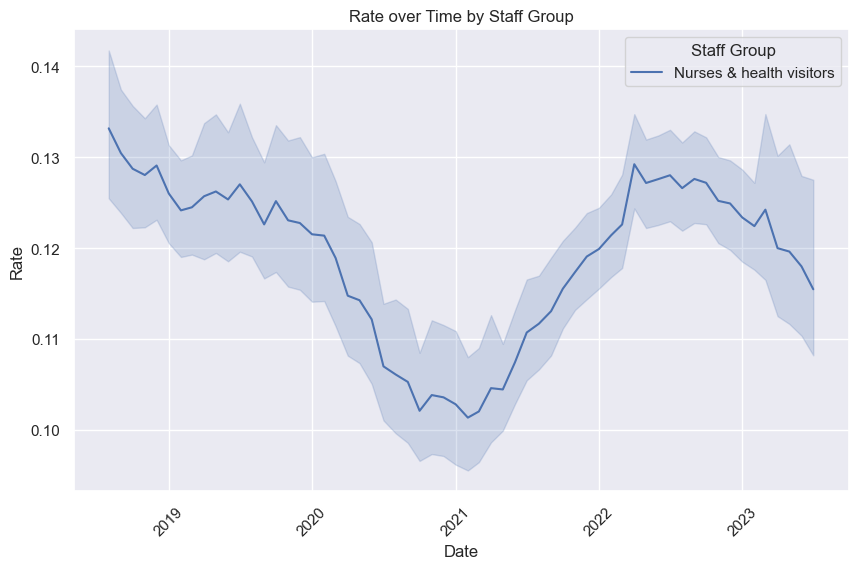

In [24]:
sns.set()

plt.figure(figsize=(10, 6))  
sns.lineplot(data=test_sg, x='month_year', y='rate', hue='staff_group')
plt.xlabel('Date')
plt.ylabel('Rate')
plt.title('Rate over Time by Staff Group')
plt.legend(title='Staff Group', loc='best')  
plt.xticks(rotation=45)  
plt.show()

In [25]:
processed_annual_df1.to_csv('../processed_annual_turnover.csv', index=False)
#processed_monthly_df.to_csv('./tempdir/processed_monthly_data.csv', index=False)

In [26]:
#processed_monthly_df.to_csv('../processed_monthly_turnover.csv', index=False)

In [27]:
inactive_orgs.to_csv('../inactive_orgs.csv')